# Prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/github_drive/code

/content/drive/My Drive/github_drive/code


In [ ]:
!pip install sktime

     |████████████████████████████████| 5.7MB 5.0MB/s 
     |████████████████████████████████| 9.5MB 44.6MB/s 
     |████████████████████████████████| 22.2MB 56.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Perturb and Measure Metrics with Referee

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
from sktime.classification.shapelet_based import MrSEQLClassifier


from sklearn.linear_model import RidgeClassifierCV
# from scipy.interpolate import interp1d

# from utils.noise import Noise
# import utils.prep as prep
# import utils.visualize as vis
# import utils.noise as noise
# from utils.explanation import all_accuracy

# from utils.rocket_functions import generate_kernels, apply_kernels

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_dir = 'data'


## Functions to save accuracy record by Mr-SEQL and ROCKET as referee

In [ ]:
def all_accuracy_rocket(train_x, train_y, trained_model, classifier = 'MrSEQL-SM', noise_type = 1,  ds = 'CMJ'):
    '''
    Calculate accuracy for all noisy data range with test data
    '''
    ms = trained_model   
    accuracy = []
    
    col_names = ['dataset','weights', 'type', 'noise_level', 'acc']
    df = pd.DataFrame(columns = col_names)

    for noise_level in range(0,101,10):
        # load test data
        test_file  = 'output/noisy_ds/%s/%s_%s%d_type%d_TEST.txt' %(def_noise_type, ds, classifier, noise_level, noise_type)
        
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x, test_y = test_data[:,1:], test_data[:,0]
        X_test_transform = apply_kernels(X = test_x, kernels = kernels)
    
        predicted = ms.predict(X_test_transform)
        
        acc = metrics.accuracy_score(test_y, predicted)
        df = df.append({'dataset': ds,
                        'weights':c,
                        'noise_type': def_noise_type,
                        'type': noise_type,
                        'noise_level': noise_level,  
                        'acc': acc }, 
                   ignore_index=True)
        accuracy.append(acc)
    return df, np.array(accuracy)


def all_accuracy_mrseql(train_x, train_y, trained_model, classifier = 'MrSEQL-SM', noise_type = 1,  ds = 'CMJ'):
    '''
    Calculate accuracy for all noisy data range with test data
    '''
    ms = trained_model   
    accuracy = []
    
    col_names = ['dataset','weights', 'type', 'noise_level', 'acc']
    df = pd.DataFrame(columns = col_names)

    for noise_level in range(0,101,10):
        # load test data
        test_file  = 'output/noisy_ds/%s/%s_%s%d_type%d_TEST.txt' %(def_noise_type, ds, classifier, noise_level, noise_type)
        
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x, test_y = np.expand_dims(test_data[:,1:], 1), test_data[:,0]
        predicted = ms.predict(test_x)
        
        acc = metrics.accuracy_score(test_y, predicted)
        df = df.append({'dataset': ds,
                        'weights':c,
                        'noise_type': def_noise_type, 
                        'type': noise_type,
                        'noise_level': noise_level, 
                        'acc': acc }, 
                   ignore_index=True)
        accuracy.append(acc)
    return df, np.array(accuracy)

def save_weight(model, test_data, labels, predicted, ds):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(predicted)
        new_predicted = le.transform(predicted)
        weights = np.empty(dtype=float, shape=(0,test_data.shape[1]))
        
        print('   Original    predicted class: ', np.unique(predicted))
        print('   Transformed predicted class: ', np.unique(new_predicted))
        
        
        for i, ts in enumerate(test_data):
            w = model.map_sax_model(ts)
            pred_class = int(new_predicted[i])
            w = [w[pred_class]]
            
            weights = np.append(weights, w, axis = 0)
        fileName = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
        np.savetxt(fileName, weights, delimiter=",")


## 1. Train the Classifier with Mr-SEQL & save explanation **weights**

In [ ]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
for ds in ds_list:
    print(ds)
    train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')

    # load train data
    train_data = np.genfromtxt(train_file,delimiter=',')

    # train_data = np.genfromtxt(train_file)
    train_x = train_data[:,1:]
    train_y = train_data[:,0]

    # Create mrseql object
    ms = MrSEQLClassifier(seql_mode='fs')

    # Mr-SEQL Custom Configuration
    # ms.mode(seql_mode='fs') # to use SEQL as feature selection
    # ms.mode(seql_mode='clf') # to use Ensemble SEQL (default)
    # ms.symbol_representations(['sax','sfa']) # only sax by default

    # Short summary of the methods used.
    ms.summary()

    # fit training data
    ms.fit(train_x,train_y)
    
    # load test data
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x = test_data[:,1:]
    test_y = test_data[:,0]

    # # prediction
    predicted = ms.predict(test_x)

    # # Classification accuracy
    print("Accuracy with mr-seql: %2.4f" % metrics.accuracy_score(test_y, predicted))
    

    save_weight(model = ms, test_data = test_x, labels = test_y, predicted = predicted, ds = ds)
    print('DONE. weight_saved. ')
   

CBF
Symbolic methods: sax
No symbolic parameters found. To be generated later.
Classification Method: SEQL as feature selection
Accuracy with mr-seql: 0.9989
   Original    predicted class:  [1. 2. 3.]
   Transformed predicted class:  [0 1 2]
DONE. weight_saved. 
CMJ
Symbolic methods: sax
No symbolic parameters found. To be generated later.
Classification Method: SEQL as feature selection
Accuracy with mr-seql: 0.9609
   Original    predicted class:  [0. 1. 2.]
   Transformed predicted class:  [0 1 2]
DONE. weight_saved. 
Coffee
Symbolic methods: sax
No symbolic parameters found. To be generated later.
Classification Method: SEQL as feature selection
Accuracy with mr-seql: 1.0000
   Original    predicted class:  [0. 1.]
   Transformed predicted class:  [0 1]
DONE. weight_saved. 
ECG200
Symbolic methods: sax
No symbolic parameters found. To be generated later.
Classification Method: SEQL as feature selection
Accuracy with mr-seql: 0.8500
   Original    predicted class:  [-1.  1.]
   Tra

## 2. Perturb the test dataset

### Define 'Noise' Class

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math

import random as rd
import matplotlib
import sys
from scipy.interpolate import interp1d
import os



class Noise:
    def __init__(self,sequence, label, train_x, weight, dataset_name = 'JumpResampled', weight_model = 'MrSEQL'):
        self.sequence = sequence
        self.label = label
        self.train_x = train_x
        
        assert self.sequence.shape[1] == self.train_x.shape[1]
        self.weight = weight
        self.sequence_noise = None
        self.dataset = dataset_name
        self.threshold = None
        self.noise_type = None
        self.classifier = weight_model 
    def norm_weight(self):
        self.weight = abs(self.weight)
        self.weight = self.weight/self.weight.sum(axis = 1, keepdims=1)
        return self.weight

    def add_noise_zeros(self, noise_type=1, threshold=50):
        if threshold == 0: 
            self.sequence_noise = self.sequence
        
        elif threshold == 100: 
            self.sequence_noise = np.zeros(self.sequence.shape)

        else:
            self.threshold = threshold
            self.noise_type = noise_type
            if noise_type == 1:
                discrim = np.percentile(self.weight, 100-threshold, axis = 1).reshape(-1,1)
                self.sequence_noise = np.where(self.weight>=discrim, 0, self.sequence)

            elif noise_type == 2: 
                discrim = np.percentile(self.weight, threshold, axis = 1).reshape(-1,1)
                self.sequence_noise = np.where(self.weight<discrim, 0, self.sequence)
        return self.sequence_noise

    def add_noise_gaussian(self,noise_type=1,threshold = 50, type_ = 'global'):
        if threshold == 0: 
            self.sequence_noise = self.sequence

        else:
            import random
            self.threshold = threshold
            self.noise_type = noise_type
            shape0,shape1 = len(self.sequence), len(self.sequence[0])
            if type_ == 'global':
                mu = np.mean(self.train_x)
                sigma = np.std(self.train_x)

            elif type_ == 'local':
                mu = np.mean(self.train_x, axis=0)
                sigma = np.std(self.train_x, axis=0)
            else:
                print('Defined "type_" is invalid')
                return
            np.random.seed(2020)
            rand_matrix = np.random.randn(shape0,shape1)
            noise = sigma * rand_matrix + mu

            if threshold == 100: weight = np.full(shape = self.sequence.shape, fill_value = 1)
            else:
                if noise_type == 1: 
                    discrim = np.percentile(self.weight, 100-threshold, axis = 1).reshape(-1,1)
                    weight = (self.weight >= discrim) * 1
                    self.sequence_noise = np.where(self.weight>=discrim, noise, self.sequence)

                elif noise_type == 2: 
                    discrim = np.percentile(self.weight, threshold, axis = 1).reshape(-1,1)
                    weight = (self.weight < discrim) * 1
                    self.sequence_noise = np.where(self.weight<discrim, noise, self.sequence)

            # self.sequence_noise = self.sequence + np.multiply(weight,noise)

        return self.sequence_noise
    # def add_noise_gaussian_old(self,noise_type=1,threshold = 50, k=1):
    #     if threshold == 0: 
    #         self.sequence_noise = self.sequence

    #     else:
    #         import random
    #         mu = 0
    #         pct_sigma = 0.02
    #         self.threshold = threshold
    #         self.noise_type = noise_type
    #         shape0,shape1 = len(self.sequence), len(self.sequence[0])
    #         range_ = (np.amax(self.sequence) - np.amin(self.sequence)) 
    #         sigma = range_*pct_sigma
    #         np.random.seed(2020)
    #         rand_matrix = np.random.randn(shape0,shape1)
    #         noise = sigma * rand_matrix + mu

    #         if threshold == 100: weight = np.full(shape = self.sequence.shape, fill_value = 1)
    #         else:
    #             if noise_type == 1: 
    #                 discrim = np.percentile(self.weight, 100-threshold, axis = 1).reshape(-1,1)
    #                 weight = (self.weight >= discrim) * 1

    #             elif noise_type == 2: 
    #                 discrim = np.percentile(self.weight, threshold, axis = 1).reshape(-1,1)
    #                 weight = (self.weight < discrim) * 1

    #         self.sequence_noise = self.sequence + np.multiply(weight*1.5*k,noise)

    #     return self.sequence_noise


    def add_noise_local_mean(self, noise_type=1,threshold = 50):
        if threshold == 0: 
            self.sequence_noise = self.sequence
        else:
            self.threshold = threshold
            self.noise_type = noise_type
            
            centroid_val = np.mean(self.train_x, axis = 0)

            if threshold == 100: discrim_area = np.full(shape = self.sequence.shape, fill_value = 1)
            else:
                if noise_type == 1: 
                    discrim = np.percentile(self.weight, 100-threshold, axis = 1).reshape(-1,1)
                    discrim_area = (self.weight >= discrim) * 1

                elif noise_type == 2: 
                    discrim = np.percentile(self.weight, threshold, axis = 1).reshape(-1,1)
                    discrim_area = (self.weight < discrim) * 1


            self.sequence_noise = discrim_area* centroid_val + self.sequence * (discrim_area == 0)

        return self.sequence_noise


    
    def add_noise_global_mean(self, noise_type=1,threshold = 50):
        replace_val = np.mean(self.train_x)
        if threshold == 0: 
            self.sequence_noise = self.sequence
            
        elif threshold == 100: 
            self.sequence_noise = np.ones(self.sequence.shape)*replace_val

        else:
            self.threshold = threshold
            self.noise_type = noise_type
            if noise_type == 1:
                discrim = np.percentile(self.weight, 100-threshold, axis = 1).reshape(-1,1)
                self.sequence_noise = np.where(self.weight>=discrim, replace_val, self.sequence)

            elif noise_type == 2: 
                discrim = np.percentile(self.weight, threshold, axis = 1).reshape(-1,1)
                self.sequence_noise = np.where(self.weight<discrim, replace_val, self.sequence)
        return self.sequence_noise

    
    def visualize(self,idx):
        plt.figure(figsize = (10,6))
        plt.plot(self.sequence_noise[idx])
        plt.plot(self.sequence[idx])
        plt.legend(['Noisy', 'Original'], loc='lower right')
        plt.title('Signal with Type {} noise with threshold = {} at index {}'.format(self.noise_type, self.threshold, idx), fontdict = {'fontsize' : 12})

    def save(self):
        import utils.prep as prep
        
        txt = self.dataset + '_' + self.classifier + str(self.threshold) + '_type' + str(self.noise_type)
        
        prep.write_to_std(self.sequence_noise, self.label, dataset= txt, train = False)

### Perturb with weights from a method

zero
Dataset: Coffee
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
DONE
gaussian_local
Dataset: Coffee
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
DONE
gaussian_global
Dataset: Coffee
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
DONE
mean_global
Dataset: Coffee
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.

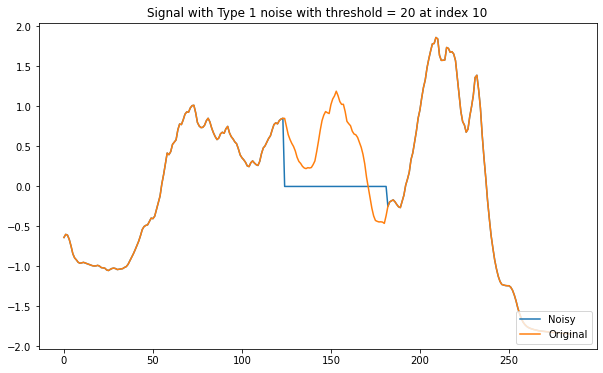

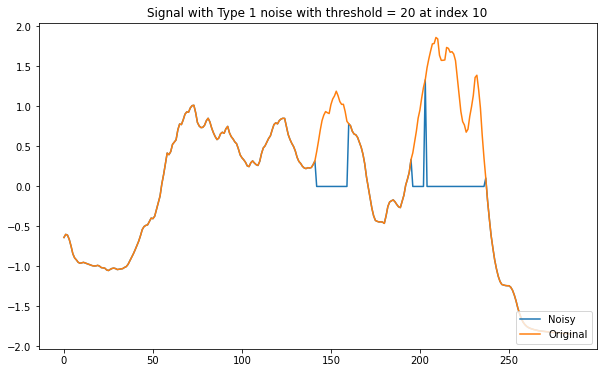

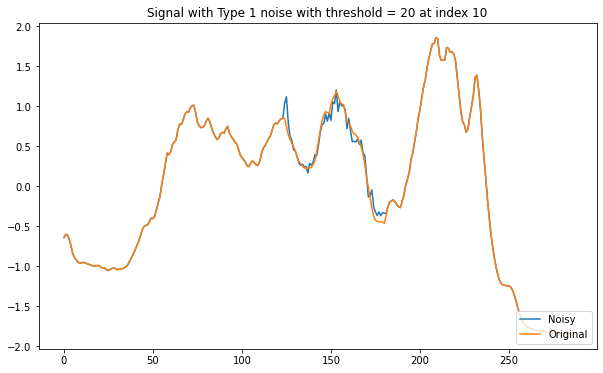

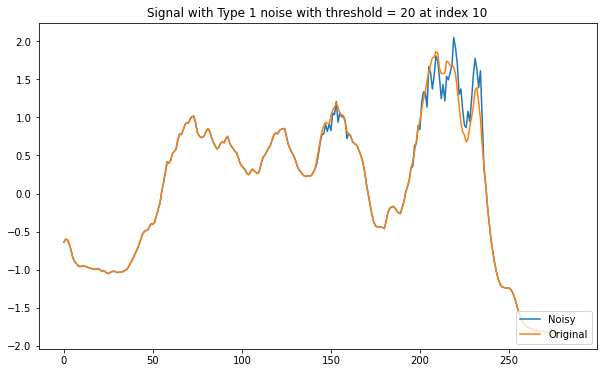

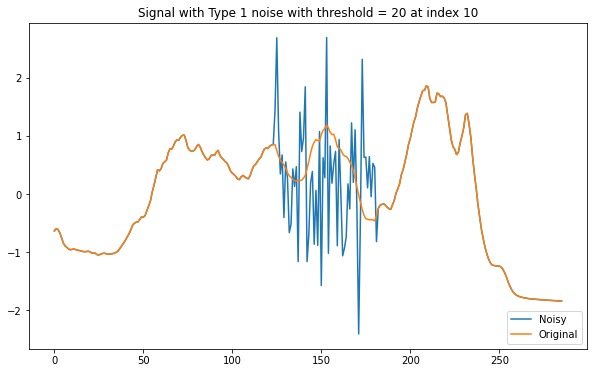

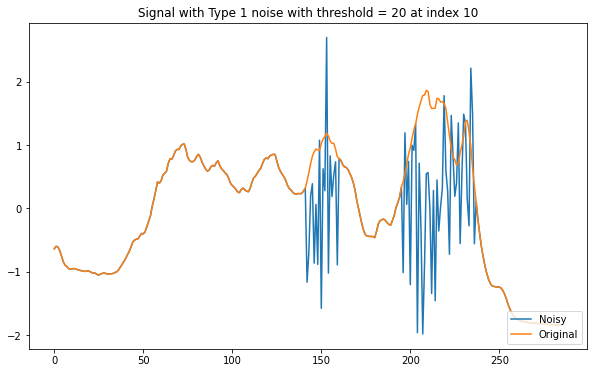

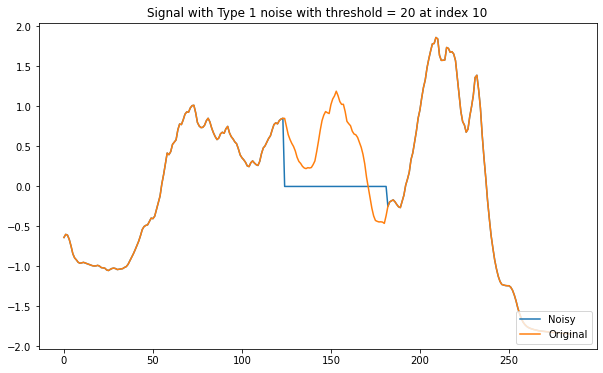

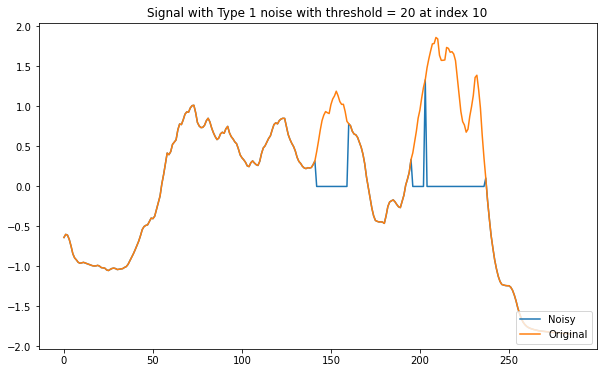

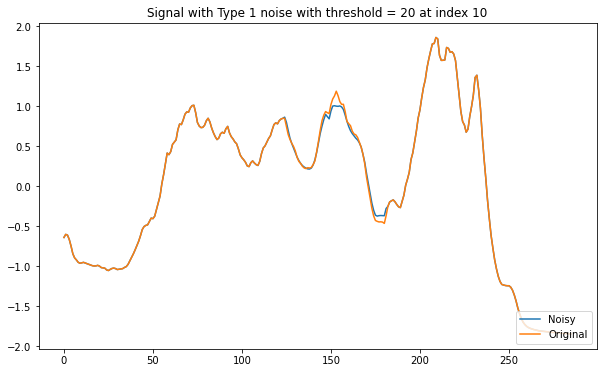

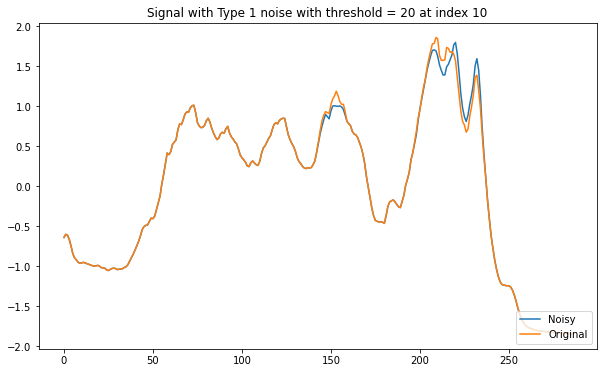

In [ ]:
import utils.prep as prep

# ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_list = ['Coffee']
explanation_others = ['MrSEQL-SM', 'ResNetCAM']
explanation_CMJ = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME']
# def_noise_type = 'gaussian_local'
def_noise_type_list = ['zero', 'gaussian_local', 'gaussian_global', 'mean_global', 'mean_local']
# def_noise_type_list = ['zero']
for def_noise_type in def_noise_type_list:
    print(def_noise_type)
    for ds in ds_list:
        print('Dataset: %s' %ds)
        explanation_list = explanation_CMJ if ds in ['CMJ','GunPoint'] else explanation_others
        
        test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x = test_data[:,1:]
        test_y = test_data[:,0]
        
        train_file  = os.path.join(ds_dir, ds, ds+'_TRAIN')
        train_data = np.genfromtxt(train_file, delimiter=',')
        train_x = train_data[:,1:]
        train_y = train_data[:,0]
        
        
            
        for c in explanation_list:
            print('.   Perturbing test data with weights from %s' %c)
            if c == 'MrSEQL-SM':       test_weight_file = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
            elif c == 'MrSEQL-LIME':    test_weight_file = 'output/explanation_weight/weights_LIME_%s.txt' % ds
            elif c == 'ResNetCAM':      test_weight_file = 'output/resnet_weights/ResNet_%s_BestModel.hdf5_model_weights.txt' % ds
            else: 
                print('ERROR')
                break
            test_weight = np.genfromtxt(test_weight_file, delimiter = ',')
            if c =='MrSEQL-LIME': test_weight = np.repeat(test_weight, test_x.shape[1]//10).reshape(len(test_y),-1)
            noise = Noise(test_x,test_y,train_x,test_weight, dataset_name= ds)
            noise.norm_weight()
            for noise_type in [1,2]:
                for t in range(0,101,10):
                    if def_noise_type == 'zero':
                        n = noise.add_noise_zeros(noise_type = noise_type, threshold = t)
                    elif def_noise_type == 'gaussian_local':
                        n = noise.add_noise_gaussian(noise_type = noise_type, threshold = t, type_ = 'local')
                    elif def_noise_type == 'gaussian_global':
                        n = noise.add_noise_gaussian(noise_type = noise_type, threshold = t, type_ = 'global')
                    elif def_noise_type == 'mean_local':
                        n = noise.add_noise_local_mean(noise_type = noise_type, threshold = t)
                    elif def_noise_type == 'mean_global':
                        n = noise.add_noise_global_mean(noise_type = noise_type, threshold = t)

                    else:
                        print('defined "noise_type" is invalid')
                        break

                    txt = 'noisy_ds/%s/%s_%s%d_type%d' %(def_noise_type,ds, c, t, noise_type)
                    
                    
                    if ds == 'Coffee' and t == 20 and noise_type == 1:
                        noise.visualize(10)
                    # prep.write_to_std(n, test_y, dataset= txt, train = False)
        
            print('.   Done perturbation for test data with weights from %s' %c)
        print('DONE')

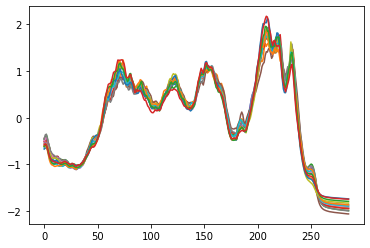

In [ ]:
# plt.plot(train_x[-1])
# plt.plot(train_x[0])

for i in range(28):
  if train_y[i] == 0:
    plt.plot(train_x[i])



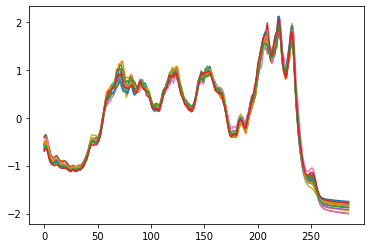

In [ ]:
# plt.plot(train_x[-1])
# plt.plot(train_x[0])

for i in range(28):
  if train_y[i] == 1:
    plt.plot(train_x[i])

### Perturb with weights from a random explanation

In [ ]:
import utils.prep as prep

# ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_list = ['CMJ']
explanation_others = ['MrSEQL-SM', 'ResNetCAM']
explanation_CMJ = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME']
random_exp = True
def_noise_type_list = ['zero', 'gaussian_local', 'gaussian_global', 'mean_global', 'mean_local']

for def_noise_type in def_noise_type_list:
    for ds in ds_list:
        print('Dataset: %s' %ds)
        explanation_list = explanation_CMJ if ds in ['CMJ','GunPoint'] else explanation_others
        
        test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x = test_data[:,1:]
        test_y = test_data[:,0]
        
        train_file  = os.path.join(ds_dir, ds, ds+'_TRAIN')
        train_data = np.genfromtxt(train_file, delimiter=',')
        train_x = train_data[:,1:]
        train_y = train_data[:,0]
        
        print('.      Preturbing test data with Random Explanation')
        np.random.seed(2020)
        test_weight = np.random.uniform(0,100,size=test_x.shape)
        if random_exp == True: c = 'Random'
        else: break

        for def_noise_type in def_noise_type_list:
            noise = Noise(test_x,test_y,train_x,test_weight, dataset_name= ds)
            noise.norm_weight()
            for noise_type in [1,2]:
                for t in range(0,101,10):
                    if def_noise_type == 'zero':
                        n = noise.add_noise_zeros(noise_type = noise_type, threshold = t)
                    elif def_noise_type == 'gaussian_local':
                        n = noise.add_noise_gaussian(noise_type = noise_type, threshold = t, type_ = 'local')
                    elif def_noise_type == 'gaussian_global':
                        n = noise.add_noise_gaussian(noise_type = noise_type, threshold = t, type_ = 'global')
                    elif def_noise_type == 'mean_local':
                        n = noise.add_noise_local_mean(noise_type = noise_type, threshold = t)
                    elif def_noise_type == 'mean_global':
                        n = noise.add_noise_global_mean(noise_type = noise_type, threshold = t)

                    else:
                        print('defined "noise_type" is invalid')
                        break

                    txt = 'noisy_ds/%s/%s_%s%d_type%d' %(def_noise_type,ds, c, t, noise_type)
                    
                    
                    # if ds == 'CMJ' and t == 100 and noise_type == 1:
                        # noise.visualize(100)
                    prep.write_to_std(n, test_y, dataset= txt, train = False)
        
            print('.   Done perturbation for test data with weights from %s' %c)
        print('DONE')

Dataset: CMJ
.      Preturbing test data with Random Explanation
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
DONE
Dataset: CMJ
.      Preturbing test data with Random Explanation
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
DONE
Dataset: CMJ
.      Preturbing test data with Random Explanation
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
.   Done perturbation for test data with weights from Random
. 

## 3. Get new accuracy scores and the explanation AUC

### 3.1 Use Mr-SEQL as the referee classifier

In [ ]:
# ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_list = ['CMJ']
ds_dir = 'data'

col_names1 = ['dataset', 'weights', 'type', 'explanation_auc']
auc_df_1 = pd.DataFrame(columns = col_names1)

col_names3 = ['dataset', 'weights','type', 'noise_level', 'acc']
acc_df_1 = pd.DataFrame(columns = col_names3)

weights_from_classifier_others = ['MrSEQL-SM', 'ResNetCAM', 'Random']
weights_from_classifier_LIME = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME', 'Random']

def_noise_type_list = ['zero', 'gaussian_local', 'gaussian_global', 'mean_global', 'mean_local']

for def_noise_type in def_noise_type_list:
    print('Noise_type: %s' % def_noise_type)
    for ds in ds_list:
        print('Dataset: %s' %ds)
        train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
        train_data = np.genfromtxt(train_file,delimiter=',')
        train_x, train_y = np.expand_dims(train_data[:,1:], 1), train_data[:,0]
        
        ##fit a classifier: MrSEQL
        ms = MrSEQLClassifier(seql_mode="fs")
        ms.fit(train_x,train_y)
        
        weight_list = weights_from_classifier_LIME if ds in ['CMJ', 'GunPoint'] else weights_from_classifier_others
        
        for c in weight_list:
            print('.   Perturbed with weights from %s' %c)
            for noise_type in [1,2]:
                local_df, acc = all_accuracy_mrseql(train_x, train_y,  ms, noise_type = noise_type,  
                                                    classifier = c, ds = ds)

                acc_df_1 = pd.concat([acc_df_1,local_df],ignore_index=True)
                steps = np.arange(0,1.1, 0.1)
                exp_auc = metrics.auc(steps, acc)
                print('.        Type %d Explanation AUC: %.4f' %(noise_type, exp_auc))
                auc_df_1 = auc_df_1.append({'dataset': ds, 
                                            'noise_type': def_noise_type,  
                                            'weights': c, 
                                            'type': noise_type,
                                            'explanation_auc': exp_auc }, ignore_index=True)
                
df1, df2 = auc_df_1.round(4), acc_df_1.round(4)
out1, out2 = 'csvout/%s/auc_df_mrseql.csv' % def_noise_type, 'csvout/%s/acc_df_mrseql.csv' % def_noise_type
df1.to_csv(out1, index=False)
df2.to_csv(out2, index=False)

Noise_type: zero
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.5936
.        Type 2 Explanation AUC: 0.7075
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.6528
.        Type 2 Explanation AUC: 0.7416
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.6271
.        Type 2 Explanation AUC: 0.7031
.   Perturbed with weights from Random
.        Type 1 Explanation AUC: 0.6288
.        Type 2 Explanation AUC: 0.6209
Noise_type: gaussian_local
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.5061
.        Type 2 Explanation AUC: 0.8223
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.6760
.        Type 2 Explanation AUC: 0.6687
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.5075
.        Type 2 Explanation AUC: 0.7690
.   Perturbed with weights from Random
.        Type 1 Explanation AUC: 0.6

### 3.2 Use ROCKET as the referee classifier

In [ ]:
# ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_list = ['CMJ']
ds_dir = 'data'


col_names1 = ['dataset', 'weights', 'type', 'explanation_auc']
auc_df = pd.DataFrame(columns = col_names1)

col_names3 = ['dataset', 'weights','type', 'noise_level', 'acc']
acc_df = pd.DataFrame(columns = col_names3)


weights_from_classifier_others = ['MrSEQL-SM', 'ResNetCAM', 'Random']
weights_from_classifier_LIME = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME', 'Random']

def_noise_type_list = ['zero', 'gaussian_local', 'gaussian_global', 'mean_global', 'mean_local']


for def_noise_type in def_noise_type_list:
    print('Noise_type: %s' % def_noise_type)
    for ds in ds_list:
        print('Dataset: %s' %ds)
        
        train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
        train_data = np.genfromtxt(train_file,delimiter=',')
        train_x, train_y = train_data[:,1:], train_data[:,0]
        
        # fit a classifier
        # (1) generate random kernels
        kernels = generate_kernels(input_length = train_x.shape[1], num_kernels = 10_000)

        # (2) transform the training data and train a classifier
        X_training_transform = apply_kernels(X = train_x, kernels = kernels)    
        
        ms = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
        ms.fit(X_training_transform, train_y)
        weight_list = weights_from_classifier_LIME if ds in ['CMJ','GunPoint'] else weights_from_classifier_others
    #     weight_list = ['MrSEQL-LIME']
        
        for c in weight_list:
            print('.   Perturbed with weights from %s' %c)
            for noise_type in [1,2]:
                local_df, acc = all_accuracy_rocket(train_x, train_y,  ms, noise_type = noise_type,  
                                                    classifier = c, ds = ds)

                acc_df  = pd.concat([acc_df,local_df],ignore_index=True)
                steps = np.arange(0,1.1, 0.1)
                exp_auc = metrics.auc(steps, acc)
                print('.        Type %d Explanation AUC: %.4f' %(noise_type, exp_auc))
                auc_df = auc_df.append({'dataset': ds, 
                                            'noise_type': def_noise_type,  
                                            'weights': c, 
                                            'type': noise_type,
                                            'explanation_auc': exp_auc }, ignore_index=True)
                
df1, df2 = auc_df_1.round(4), acc_df_1.round(4)
                
out1, out2 = 'csvout/%s/auc_df_rocket.csv' % def_noise_type, 'csvout/%s/acc_df_rocket.csv' % def_noise_type
df1.to_csv(out1, index=False)
df2.to_csv(out2, index=False)

Noise_type: zero
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.4763
.        Type 2 Explanation AUC: 0.7025
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.7014
.        Type 2 Explanation AUC: 0.7338
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.5383
.        Type 2 Explanation AUC: 0.6578
.   Perturbed with weights from Random
.        Type 1 Explanation AUC: 0.6997
.        Type 2 Explanation AUC: 0.6947
Noise_type: gaussian_local
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.5455
.        Type 2 Explanation AUC: 0.7827
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.6564
.        Type 2 Explanation AUC: 0.6930
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.5567
.        Type 2 Explanation AUC: 0.8014
.   Perturbed with weights from Random
.        Type 1 Explanation AUC: 0.6

NameError: ignored